# HR (Hertzsprung-Russell) Diagram Exercise

The [Hertzsprung-Russell diagram](https://en.wikipedia.org/wiki/Hertzsprung–Russell_diagram) is a fundamental diagram in astronomy that displays important relationships between the stellar color (or temperature) and absolute brightness (or luminosity).

In this exercise, we will use existing stellar catalogs to produce the H-R diagram.

In [1]:
# As a hint, we include the code block for Python modules that you will likely need to import:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# For downloading files
from astropy.utils.data import download_file
from astropy.io import fits

import pyvo as vo
from pyvo import registry

## There are a number of relatively unimportant warnings that
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore", module="astropy.io.votable.*")
warnings.filterwarnings("ignore", module="pyvo.utils.xml.*")

## Step 1: Find appropriate catalogs

We want to find a star catalog that has the available data to produce the H-R diagram, i.e., the absolute magnitudes (or both apparent magnitudes AND distances, so we can calculate the absolute magnitudes) in two optical bands (e.g., B and V). This would give us color. Or we need B- OR V- band magnitude and the stellar temperature.

To simplify this problem, we want to find a catalog of an open cluster of stars, where all the stars were born around the same time and are located in one cluster. This simplifies the issue of getting accurate distances to the stars. One famous cluster is the Pleiades in the constellation of Taurus. So first we start by searching for an existing catalog with data on Pleiades that will provide the necessary information about the stars: magnitudes in two bands (e.g., B and V), which can be used to measure color, or temperature of the star plus one magnitude.

### DATA DISCOVERY STEPS

Here is useful link for [how the pyvo registry search works](https://pyvo.readthedocs.io/en/latest/registry/index.html).

In [2]:
# Write some code to perform a registry search using
# appropriate keywords and specify the service type.
# Also apply the includeaux=True option to return
# the maximum number of services:


# Print the size of the output table and get a summary of the sources:

Note: The includeaux=True includes auxiliary services.

Because we specified the service type, this returns only the TAP services for each of the avalible resorces matching our search criteria.  So, the 'interfaces' column will only show TAP service as an avalible service, even if other services are avalible from the same resource. We know we need the service to be a TAP service since we know that we want to eventually access the search using additional column information (i.e., beyond RA and Dec, which is all that Simple Cone Search returns).

#### Next, we need to find which of these has the columns of interest, i.e. magnitudes in two bands to create the color-magnitude diagram

We can re-run the registry search, but further restrict the results by column UCD.  We want tables that have magnitude columns; the most basic UCD to describe a magnitude column is phot.mag

In [3]:
# Perform another registry search, this time searching
# tables that have at least 1 magnitude column.
# Note: '%' serves as a wild card when searching columns

# How many tables do you get?

Note: the '%' serves as a wild card when searching by UCD

The IOVA standard enables resources to be as sepecific as they would like when defining the UCD of columns.  For example, 'phot.mag' and 'phot.mag;em.opt.V' can both be used to describe a column containing the V magnitudes of objects.  If a resource uses the latter to describe a column, a search using 'phot.mag' will not return that resource.  A wild card would need to be used or the exact column UCD. The UCD search requires an exact match for a resource to be returned, so using the wild card will make it easier to discover a wider variety of resources.

So using this we can reduce the matched tables to ones that are a bit more catered to our experiment. Note, that there is redundancy in some resources since these are available via multiple services and/or publishers. Therefore a bit more cleaning can be done to provide only the unique matches.

In [4]:
# Print the 'ivoid' column for these tables

In [5]:
# Write a function that searches the result and only
# outputs unique tables

We can read more information about the results we found.  For each resource element (i.e. row in the table above), there are useful attributes, which are [described here]( https://pyvo.readthedocs.io/en/latest/api/pyvo.registry.regtap.RegistryResource.html#pyvo.registry.regtap.RegistryResource)

In [6]:
# Output the descriptions of the resulting matches:

<i> RESULT: Based on these, the second one (by Eichhorn et al) looks like a good start. </i>

### At this point, you can proceed to Step 2

-- OR --

### Try a different data discovery method

### Alternative Method: Use ADS to search for appropriate paper and access data via NED

There are multiple paths for the data discovery. So it may also be that you know the paper that has the data you are interested in and want to access via the bibcode or authors, etc.

In this case, let's assume that we have the information that the Eichhorn+1970 paper has the data that we need to create the H-R diagram: <https://ui.adsabs.harvard.edu/abs/1970MmRAS..73..125E/abstract>

We can either search by bibcode (1970MmRAS..73..125E) or "Eichhorn" to get the access_urls that will allow us to work with the data.

Before this step, if may help to see the names of the fields available to use. Notice the following fields:

"source_value" contains the bibcode information that we want; "creator_seq" lists the authors;

and

"access_url" provides the url from where the data can be accessed.

In [7]:
# Print the fieldnames for the tap services.

First, Try using bibcode:

In [8]:
bibcode = '1970MmRAS..73..125E' # Eichhorn

#
# print "short_name", "source_value" and "access_url" information
# for the table entry that matches this bibcode.
#
#  Note that using the to_table() lets you search the result
#   easily using all columns.  But in the end, you want to get
#   back not an astropy table row, which you cannot use, but the
#   original RegistryResult that has the callable TAP service.

Note that the URL is a generic TAP url for Vizier.  All of its tables can be accessed by that same TAP services.  It'll be in the ADQL query itself that you specify the table name.  We'll see this below.

Next, try using Author name:

In [9]:
author = 'Eichhorn'

#
# print "short_name", "reference_url" and "access_url" information
# for the table entry that matches this author name.
#
# Hint: The pyVO Registry resource page may help:
# https://pyvo.readthedocs.io/en/latest/api/pyvo.registry.regtap.RegistryResource.html#pyvo.registry.regtap.RegistryResource.search

These examples provide a few ways to access the information of interest.

Below are a few other ways to see what the tap_service table contains.

1. To view the column information: tap_services.to_table().columns() shows the metadata contained in the tap service. We will reference some of this columns below as we try to find the appropriate table.

2. tap_services[index].describe(): The table with the tap_services output has, in our case, 83 tables listed and each includes metadata containing some human readable description. You can get the description for one case or for all the records by iterating through the resource. In the former case, we show the description for the Eichhorn data. The latter case also follows.

In [10]:
# Print the full description for the Eichhorn+1970 example.

## Step 2: Acquire the relevant data and make a plot

In order to query the table, we need the table name, note this is NOT the same as the short name we found above:

In [11]:
# Get the table name for the Eichhorn+1970 data

In [12]:
# Query the data to output the table information (i.e. the data in the
# columns in the table)

We can access the column data as array using the .getcolumn(colname) attribute, where the colname is given in the table above. In particular the "CI" is the color index and "Ptm" is the photovisual magnitude. See [here](https://vizier.u-strasbg.fr/viz-bin/VizieR?-source=I/90) for details about the columns.

In [13]:
# get color and magnitude column information for
# stars in this table.

### Plotting

Note: The magnitudes here are apparent and therefore in plotting, the color-magnitude diagram is typically brightness increasing upwards (higher y-axis) so we will flip the y-axis here.

Text(0.5, 0, 'B-V')

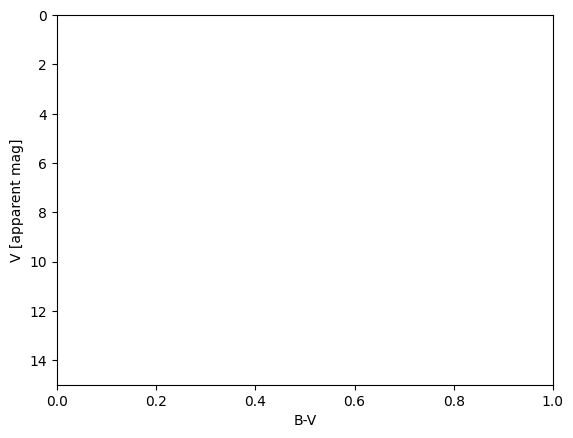

In [14]:
plt.ylim(15, 0)
plt.ylabel("V [apparent mag]")
plt.xlabel("B-V")
#
# plot color and magnitude data:


## Step 3. Compare with other color-magnitude diagrams for Pleiades

There is nice discussion here: <http://www.southastrodel.com/Page03009a.htm>  about the color-magnitude diagram. Their Fig 4 looks slightly cleaner because part of this investigation was to select the 270 stars that are vetted members and restricted to stellar types more massive than K0.

The dataset is from Raboud+1998 (1998A&A...329..101R)

Therefore in this next step, we will use the bibcode to select this data and overplot with the previous data to compare.

In [15]:
bibcode = '1998A&A...329..101R' # Raboud

# Repeat steps above with this other dataset:
# First find the table usign the bib code

In [16]:
# Then query the table using the table name and get the
# appropriate columns

Text(0.5, 0, 'B-V')

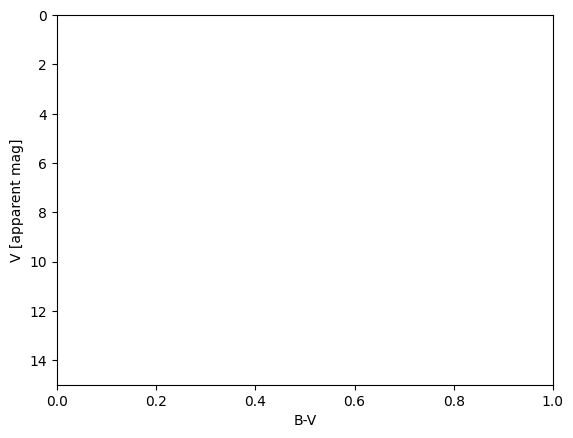

In [17]:
# Then plot!

plt.ylim(15, 0)
plt.ylabel("V [apparent mag]")
plt.xlabel("B-V")

# Plot the Eichhorn data as black circles and
# Raboud data as red squares.

## BONUS: Step 4: The CMD as a distance indicator

Since the y-axis above is apparent magnitude, we can use the obvious features (e.g., main sequence curve) to translate the apparent magnitudes to absolute magnitudes (by comparing to published H-R diagrams given in absolute magnitudes) and measure the distance to Pleiades!

In [18]:
sun_color = 0.65  # from http://www.astro.ucla.edu/~wright/magcolor.htm

# Based on the color-magnitude diagram, what would be
# the Sun's apparent magnitude at the distance of the Pleiades?
# i.e. if you overplot the Sun on the CMD above
# what's the Sun's magnitude, corresponding to the sun's color
# given as B-V=0.65?

# Overplot the sun in the plot above for reference.


In [19]:
# Measure the distance to the Pleaides, using the Sun
# as a reference. We know the Sun's absolute magnitude:
Vabs = 4.8   ## Sun @ B-V = 0.65 (taken from Wikipedia)

# Using the Sun's apparent magnitude from your estimate above
# what's the distance to Pleiades in pc?

True distance to Pleaides is 136.2 pc  (<https://en.wikipedia.org/wiki/Pleiades> ). Not bad!